<br>
<font color="#500000" size=15 style="margin:2cm"> AGGREGATIBACTER FUSE</font>



# INFORMATIVNOST VIROV ZA  REKONSTRUKCIJO RBP/DBP

In [1]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from skfusion import fusion
from cross_validation import *
import pickle
from math import ceil
import time
from joblib import Parallel, delayed
from copy import deepcopy

from scipy.stats import ranksums
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

# Matrices Import

In [2]:
prot_rna = pickle.load(open('../matrices/pickles/cr_z-score_raw.pkl', 'rb'))
secretion_prot = pickle.load(open('../matrices/pickles/signalP.pkl', 'rb'))
rna_expression = pickle.load(open('../matrices/pickles/MA_exp.pkl', 'rb'))
s4te_prot = np.load(open('../matrices/pickles/S4TE.npy', 'rb'))
OG_prot = np.load(open('../matrices/pickles/OG_prot.npy', 'rb')) # this is orthology function
rna_GO = np.load(open('../matrices/pickles/HSgene_GO.npy', 'rb'))

gproOG_prot = np.load(open('../matrices/pickles/aaprot_gprobOG.npy', 'rb'))
hsgene_gproOG = np.load(open('../matrices/pickles/hsprot_gprobOG_short.npy', 'rb'))
aaexp_prot = np.load(open('../matrices/pickles/aa_fc_expressions.npy', 'rb'))
rbp_prot = np.load(open('../matrices/pickles/RBPdomains.npy', 'rb'))
secretionexp_prot = np.load(open('../matrices/pickles/Secretedprot_exp.npy', 'rb'))

# Data transformation

In [3]:
# remove data for genes with no catrapid prediction and shape correctly everthing

secretionexp_prot = secretionexp_prot.reshape(1, secretionexp_prot.size, )
rbp_prot = rbp_prot.T
selection = prot_rna.any(axis=1)
prot_rna = prot_rna[selection,:]
secretion_prot = secretion_prot[:, selection]
s4te_prot = s4te_prot[:, selection]
OG_prot = OG_prot[:, selection]
gproOG_prot = gproOG_prot.T[:, selection]

# Addd pseudo rows 
secretion_prot = np.vstack((secretion_prot, secretion_prot, secretion_prot, secretion_prot, secretion_prot))
secretionexp_prot = np.vstack((secretionexp_prot, secretionexp_prot, secretionexp_prot, secretionexp_prot, secretionexp_prot))

rbp_prot = np.vstack((rbp_prot, rbp_prot, rbp_prot, rbp_prot, rbp_prot))

rna_expression = rna_expression.reshape(rna_expression.shape[0],1)
rna_expression = np.hstack((rna_expression, rna_expression, rna_expression, rna_expression, rna_expression))

aaexp_prot = np.reshape(aaexp_prot, (1, aaexp_prot.size))
aaexp_prot = np.vstack((aaexp_prot, aaexp_prot, aaexp_prot, aaexp_prot, aaexp_prot))[:, selection]

# Add sum to S4te Results
s4te_prot[1,:] = s4te_prot[1,:] * 3
s4te_sum = s4te_prot.sum(axis=0) / s4te_prot.sum(axis=0).max()
s4te_prot = np.vstack((s4te_prot,s4te_sum))


# Display shapes
print('secretion_prot:', secretion_prot.shape)
print('rna_expression:', rna_expression.shape)
print('prot_rna:', prot_rna.shape)
print('s4te_prot:', s4te_prot.shape)
print('OG_prot:', OG_prot.shape)
print('gproOG_prot', gproOG_prot.shape)
print('hsgene_gproOG', hsgene_gproOG.shape)
print('aaexp_prot', aaexp_prot.shape)
print('rna_GO', rna_GO.shape)
print('rbp_prot', rbp_prot.shape)
print('secretionexp_prot', secretionexp_prot.shape)

secretion_prot: (5, 2001)
rna_expression: (7097, 5)
prot_rna: (2001, 7097)
s4te_prot: (13, 2001)
OG_prot: (22, 2001)
gproOG_prot (825, 2001)
hsgene_gproOG (7097, 825)
aaexp_prot (5, 2001)
rna_GO (7097, 285)
rbp_prot (5, 2001)
secretionexp_prot (5, 2001)


# Data fusion setup

In [4]:
# SETUP of variables!
k_perc = 0.025
auc_th = 1

# log file
log_file = open('./logs/temp_CR_reconstruct_full_auc{}_kperc{}.txt'.format(auc_th, k_perc), 'a')


print(('#############'
      'New analysis'
      '#############'
      '\nran on: {}' 
      '\n######################################'
      '\nAUC_th = {}'
      '\nK_perc = {}'
      '\n######################################').format(time.strftime("%d.%m.%Y %H:%M:%S"),auc_th, k_perc), file=log_file)

In [5]:
k_select = lambda x: max((ceil(x * k_perc), 2))

# Define names
secretion = fusion.ObjectType('SignalP', k_select(secretion_prot.shape[0]))
prot = fusion.ObjectType('AAprot', k_select(prot_rna.shape[0]))
genes = fusion.ObjectType('HSgenes', k_select(prot_rna.shape[1]))
GO = fusion.ObjectType('GOterms', k_select(rna_GO.shape[1]))

secretion_exp = fusion.ObjectType('SecritionMS', k_select(secretionexp_prot.shape[0]))
rbp = fusion.ObjectType('RBPs', k_select(rbp_prot.shape[0]))

# TODO: lower when possible
expr = fusion.ObjectType('HSexpression', k_select(rna_expression.shape[1]))
t4e = fusion.ObjectType('Type4eff', k_select(s4te_prot.shape[0]))
OGfg = fusion.ObjectType('orthologs_group_functions', k_select(OG_prot.shape[0]))
gproOG = fusion.ObjectType('orthologs_groups', k_select(gproOG_prot.shape[0]))
aaexp = fusion.ObjectType('AAexpression', k_select(aaexp_prot.shape[0]))

# Define relations
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_expression, genes, expr, name='HS_foldchange'),
             fusion.Relation(secretion_prot, secretion, prot, name='signalP'),
             fusion.Relation(secretionexp_prot, secretion_exp, prot, name='SecretionMS'),
             fusion.Relation(rbp_prot, rbp, prot, name='RBP_domains'),
             fusion.Relation(s4te_prot, t4e, prot, name='T4E'),
             fusion.Relation(aaexp_prot, aaexp, prot, name='AA_foldchange'),
             fusion.Relation(OG_prot, OGfg, prot, name='OG_Function'),
             fusion.Relation(rna_GO, genes, GO, name='GO_groups'),
             fusion.Relation(gproOG_prot, gproOG, prot, name='OG_proteins'),
             fusion.Relation(hsgene_gproOG, genes, gproOG, name='OG_rna')]


all_object = [secretion, prot, genes, GO, expr, t4e, OGfg, gproOG, aaexp, secretion_exp, rbp]
for objx in all_object:
    print(objx, objx.rank)


SignalP 2
AAprot 51
HSgenes 178
GOterms 8
HSexpression 2
Type4eff 2
orthologs_group_functions 2
orthologs_groups 21
AAexpression 2
SecritionMS 2
RBPs 2


# Validation Functions

In [6]:
def dfmc(seed, relations):
    return fusion.Dfmc(random_state=seed).fuse(fusion.FusionGraph(relations))


# RBP domains
def paralel_rbp_CV(relations, cv_matrix, elements, sp_idx, true_vals1, true_vals2):
    xrel = deepcopy(relations)
    xrel[sp_idx].data = cv_matrix
    xfuser = dfmc(1, xrel)
    pred_vals = xfuser.complete(xfuser.fusion_graph['RBP_domains'])[0, elements].flatten()

    true_vals1 = true_vals1[elements]
    true_vals2 = true_vals2[elements]
    fpr1, tpr1, thresholds = metrics.roc_curve(true_vals1, pred_vals)
    fpr2, tpr2, thresholds = metrics.roc_curve(true_vals2, pred_vals)
    return metrics.auc(fpr1, tpr1), metrics.auc(fpr2, tpr2)


def CV_rbp_auc(relations, cv_fold=10, th=2.5, random_state=1, alternative=0):
    sp_idx = relations.index(fusion.Relation(rbp_prot, rbp, prot, name='RBP_domains'))
    orig_matrix = relations[sp_idx].data
    true_vals1 = (orig_matrix[0, :] == 1).flatten() * 1
    true_vals2 = (orig_matrix[0, :] >= 0.5).flatten() * 1
    return Parallel(n_jobs=cv_fold)(delayed(paralel_rbp_CV)(relations, cv_matrix.T, elements, sp_idx, true_vals1, true_vals2) for cv_matrix, elements in matrix_cv_setup(orig_matrix.T, alternative=alternative, by_row=True, n_fold=cv_fold))


In [7]:
def plot_results(plt_vals, ylab =''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylabel(ylab)
    flierprops = dict(marker='o', markerfacecolor='blue', linestyle='none');
    boxprops= dict( color='blue', linewidth=2)
    capprops = dict(color='blue', linewidth=2)
    medianprops = dict(color='blue', linewidth=2)
    my_bp = plt.boxplot(plt_vals, flierprops=flierprops, boxprops=boxprops, capprops=capprops, patch_artist=True);

    ax.set_xticklabels(['Odstranjen vir:\n"{}"'.format(dsrc) for dsrc in rsources]);

    for box in my_bp['boxes']:
         box.set( facecolor= 'green', alpha = 0.5 )

# Predictions and Validations

### RBP domains

We are predicting AUC

Source remove order: ['catrapid', 'HS_foldchange', 'signalP', 'SecretionMS', 'T4E', 'AA_foldchange', 'OG_Function', 'GO_groups', 'OG_proteins', 'OG_rna']
All RBP reconstructions: [(0.34002590673575134, 0.42306368330464716), (0.75323834196891193, 0.80602409638554229), (0.7370466321243524, 0.82082616179001722), (0.73510362694300524, 0.77022375215146299), (0.77784974093264247, 0.76282271944922542), (0.65220207253885998, 0.79845094664371774), (0.49158031088082904, 0.72220309810671268), (0.75582901554404147, 0.80636833046471601), (0.77979274611398963, 0.80361445783132535), (0.74158031088082899, 0.79173838209982783)]

All DBP reconstructions: [(0.46421052631578952, 0.39883417702101553), (0.80315789473684207, 0.72096947384568177), (0.78684210526315801, 0.74290535358183751), (0.69631578947368422, 0.69964718515109681), (0.36315789473684212, 0.44377972081607608), (0.67315789473684196, 0.67985887406043866), (0.40894736842105267, 0.57861635220125784), (0.79894736842105263, 0.71759472311704242), (0

/disk2/programs/anaconda/lib/python3.4/site-packages/matplotlib/patches.py:102: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


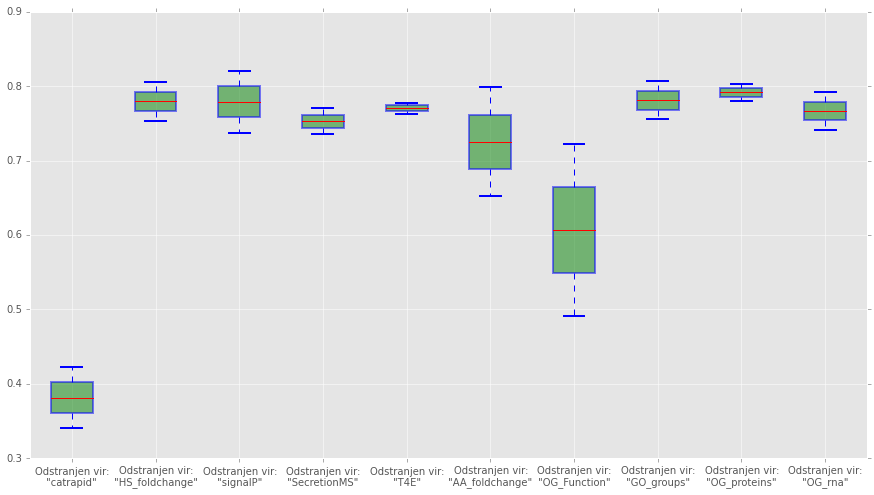

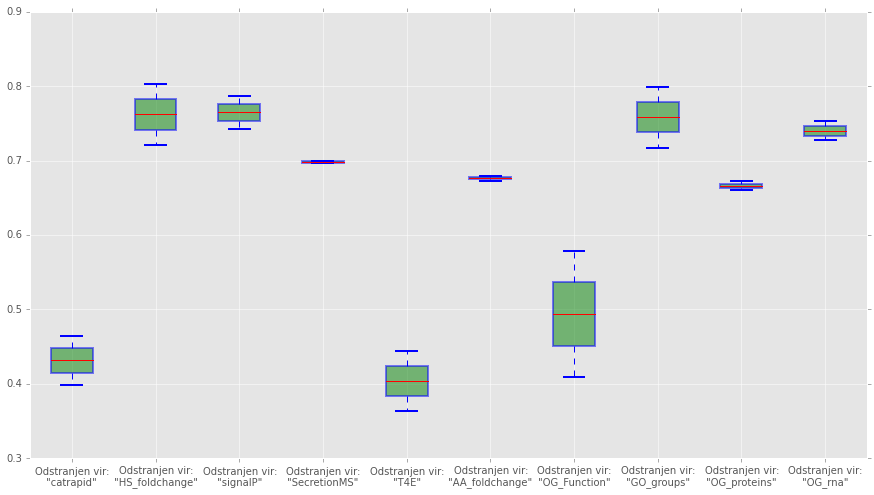

In [8]:
rbp_pred = []
dbp_pred = []
rsources = []
k_perc = 0.05

k_select = lambda x: max((ceil(x * k_perc), 2))

secretion = fusion.ObjectType('SignalP', k_select(secretion_prot.shape[0]))
prot = fusion.ObjectType('AAprot', k_select(prot_rna.shape[0]))
genes = fusion.ObjectType('HSgenes', k_select(prot_rna.shape[1]))
GO = fusion.ObjectType('GOterms', k_select(rna_GO.shape[1]))
secretion_exp = fusion.ObjectType('SecritionMS', k_select(secretionexp_prot.shape[0]))
rbp = fusion.ObjectType('RBPs', k_select(rbp_prot.shape[0]))
expr = fusion.ObjectType('HSexpression', k_select(rna_expression.shape[1]))
t4e = fusion.ObjectType('Type4eff', k_select(s4te_prot.shape[0]))
OGfg = fusion.ObjectType('orthologs_group_functions', k_select(OG_prot.shape[0]))
gproOG = fusion.ObjectType('orthologs_groups', k_select(gproOG_prot.shape[0]))
aaexp = fusion.ObjectType('AAexpression', k_select(aaexp_prot.shape[0]))

# actual relations
relations = [fusion.Relation(rbp_prot, rbp, prot, name='RBP_domains'),
         fusion.Relation(prot_rna, prot, genes, name='catrapid'),
         fusion.Relation(rna_expression, genes, expr, name='HS_foldchange'),
         fusion.Relation(secretion_prot, secretion, prot, name='signalP'),
         fusion.Relation(secretionexp_prot, secretion_exp, prot, name='SecretionMS'),
         fusion.Relation(s4te_prot, t4e, prot, name='T4E'),
         fusion.Relation(aaexp_prot, aaexp, prot, name='AA_foldchange'),
         fusion.Relation(OG_prot, OGfg, prot, name='OG_Function'),
         fusion.Relation(rna_GO, genes, GO, name='GO_groups'),
         fusion.Relation(gproOG_prot, gproOG, prot, name='OG_proteins'),
         fusion.Relation(hsgene_gproOG, genes, gproOG, name='OG_rna')]

for i in range(len(relations)-1):
    relat = relations.pop(1)
    
    x = CV_rbp_auc(relations, cv_fold=10, th=auc_th, alternative='mask')
    rbp_pred.append(x[0])
    dbp_pred.append(x[1])
    
    rsources.append(relat.name)
    relations.append(relat)


plot_results(rbp_pred)
plot_results(dbp_pred)
print('Source remove order:', rsources)
print('All RBP reconstructions:', rbp_pred)
print()
print('All DBP reconstructions:', dbp_pred)

Zgornji graf: Napod za RBP <br/>
Spodnji graf: Napoved za RBP + DBP

prikazane so AUC vrednosti. ob odstranitvi posameznih virov